# Genetic Algorithm Example Program

This is a simple illustration of a Genetic Algorithm finding the minimum value for a Travelling Salesperson Problem, for the course Natural Computing course at University of Edinburgh. This is by no means perfect code and should not be taken as such. The code was created by Billy Lyons, and takes some inspiration from https://github.com/ezstoltz/genetic-algorithm, with some changes for ease.

#  Importing necessary libraries

In [1]:
import numpy as np
import random
import operator
import matplotlib.pyplot as plt

# Genes and Chromosomes

In this formulation the individual genes of our solutions consist of cities the agent visits along the route, the chromosome being the full route. First we make a class for each city, that contains their personal coordinates in plane, and a function for computing the distance between a given city and another.

In [2]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def distance_to(self, city):
        x = np.abs(self.x - city.x)
        y = np.abs(self.y - city.y)
        distance = np.sqrt((x*x)+(y*y))
        return distance
    
    def __repr__(self):
        return "[" + str(self.x)+","+str(self.y)+"]"

Testing gene generation

In [3]:
test_city = City(1,1)
other_city = City(4,5)

print(test_city.distance_to(other_city))
print(test_city)

5.0
[1,1]


Given that we are able to generate individual cities, we will now create our complete list of cities. This list will be where we generate our population from.

In [4]:
cities = []

NoC=32;

for i in range(NoC):
    cities.append(City((np.random.randint(0, NoC)), np.random.randint(0,NoC)))
    
print(cities)

[[4,22], [18,1], [13,17], [30,30], [14,3], [23,30], [30,12], [17,31], [5,10], [11,11], [13,1], [8,24], [24,16], [30,2], [23,25], [23,31], [7,5], [22,3], [7,27], [22,29], [9,21], [20,9], [29,14], [21,20], [3,18], [0,25], [28,20], [4,10], [13,17], [17,4], [17,0], [12,9]]


Now that we have all of our cities generated and added into a list. We will define the fuction which generates a route, this route will be a member of our population, and from this we will create our initial population. Each member of the population must vist every state in city, and return to the start, so these are sampled without replacement.

In [5]:
def create_route(cities):
    route = random.sample(cities, len(cities))
    return route

Create initial population

In [6]:
def initial_population(pop, cities):
    population = []
    
    for i in range(pop):
        population.append(create_route(cities))
    return population

# Fitness

In a genetic algorithm we need to know how good our individuals are for a number of reasons. If we are performing roulette wheel selection, we weight likelihood to breed and thus pass on genes by fitness, if we have some percentage of elitism, we may wish to keep the X most successful members of the population. As such we must define a fitness function for our routes.

In [7]:
def fitness(route):
    distance, fitness = 0.0,0.0
    for i in range(0, len(route)):
        from_city=route[i]
        to_city=route[(i+1)%len(route)]
        
        distance+=(from_city.distance_to(to_city))
    
    fitness=(1/distance)
    
    return fitness, distance

# Genetic Algorithm

We now have a population and a way to calculate fitness. We must use these to rank our population from best to worst. This is essential, as, you should weight the chance to reproduce by the fitness of each member, much in the same way that a better biological agent is more likely to pass on their genes with greater succes. Additionally, you may wish to maintain some elite members through to the next generation, so ordering is natural and makes life a lot easier.

In [8]:
def ranking_pop(population):
    fitnesses = {}
    sum_fit = 0.0
    distances = {}
    for i in range(len(population)):
        fitnesses[i], distances[i] = fitness(population[i])
        x, y = fitness(population[i])
        sum_fit += x
    return sorted(fitnesses.items(), key=operator.itemgetter(1), reverse=True), sum_fit, distances

Now that we have our sorted list, we must perform selection for the next parents of the next generation. Here we are going to replicate into the next generation a certain number of elite agents, and we take the population size minus this elitism, and draw that many members from the generation by a probability distribution which is determined by their individual fitness.

1) Why might we want to have some level of elitism?

2) Why do we use a weighted selection?

In [9]:
def selection(ranked, tot, elitism):
    probabilities = np.zeros(len(ranked))
    members = np.arange(len(ranked))
    size = len(ranked)
    elite_members = []
    for i in range(len(ranked)):
        x,y = ranked[i][0], ranked[i][1]
        if i < elitism:
            elite_members.append(x)
        probabilities[x] = y
    probabilities=probabilities/np.sum(probabilities)
    selected_members = np.random.choice(members, size-elitism, p=probabilities)
    return selected_members, elite_members

In [10]:
def mating_pool(population, selected_members, elite_members):
    mating_pool = []
    elite = []
    for i in range(len(selected_members)):
        index = selected_members[i]
        mating_pool.append(population[index])
                
    for i in range(len(elite_members)):
        index = elite_members[i]
        elite.append(population[index])        
    return mating_pool, elite

Now that we have our pool of viable mates, we randomly draw some beginning and end point for the crossover between the two chromosomes. Maintaining order.

1) Look at the below, what is happening? How is this different from point crossover in the all ones problem and the class notes?

2) Why is it important to maintaining ordering?

3) Crossover here occurs every time. How might you change this to a probabilistic method? Why might that be better/worse?


In [11]:
def breed_from_parents(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    t1,t2 = 0,0
    geneA = int(np.random.rand()*len(parent1))
    geneB = int(np.random.rand()*len(parent1))
    while geneB == geneA:
        geneB = int(np.random.rand()*len(parent1))
    
    start = min(geneA, geneB)
    end = max(geneA, geneB)
    
    for i in range(start, end):
        childP1.append(parent1[i])
    childP2 = [item for item in parent2 if item not in childP1]
    
    for i in range(len(parent1)):
        if i>=start and i<end:
            child.append(childP1[t1])
            t1+=1
        else:
            child.append(childP2[t2])
            t2+=1
    return child

In [12]:
def new_population(mating_pool, elite_pool):
    children = []
    pool = random.sample(mating_pool, len(mating_pool))
        
    for i in range(len(elite_pool)):
        children.append(elite_pool[i])
    for i in range(len(mating_pool)):
        child = breed_from_parents(pool[i], pool[len(mating_pool)-i-1])
        children.append(child)
    return children

Now that our parent population has breeded and we have generated our new population from the children and the elites who have lived into the next generation, we must go through each solution and check to see if any must be mutated. We are doing this by running through each candidate in the new population, and at each point in the chromosome we see if it will mutate here and then perform a swap.

1) Why is mutation an important part of a GA (hint: Think about the search space)?

2) If you had a chromosome reprsenting some real number e.g. 3.14159 -> chromosome 314159, how might you adapt the mutation rate?


In [13]:
def mutate(chromosome, prob_mut):
    for mutable in range(len(chromosome)):
        if (np.random.rand()<prob_mut):
            swap = np.random.randint(0, len(chromosome))
            
            cityA = chromosome[mutable]
            cityB = chromosome[swap]
            
            chromosome[mutable]=cityB
            chromosome[swap]=cityA
    return chromosome

In [14]:
def mutation_over_pop(population, prob_mut):
    mutated_pop = []
    for i in range(len(population)):
        mutated_chromo = mutate(population[i], prob_mut)
        mutated_pop.append(mutated_chromo)
    return mutated_pop

In [15]:
def new_generation(current_gen, elitism, prob_mut):
    rank, tot, distances = ranking_pop(current_gen)
    selected_members, elite_members = selection(rank, tot, elitism)
    mates, elites = mating_pool(current_gen, selected_members, elite_members)
    children = new_population(mates, elites)
    next_gen = mutation_over_pop(children, prob_mut)
    return next_gen    

Now we put everything together and run it for the generations!

In [16]:
def genetic_algorithm(population, elitism, prob_mut, generations):
    pop = initial_population(population, cities)
    ranked, tot, distances = ranking_pop(pop)
    print("Initial shortest distance: {}".format(distances[ranked[0][0]]))
    
    for i in range(generations):
        pop = new_generation(pop, elitism, prob_mut)
    
    ranked, tot, distances = ranking_pop(pop)
    print("Final shortest distance: {}".format(distances[ranked[0][0]]))
    best_route = pop[ranked[0][0]]
    return best_route

In [17]:
zz=genetic_algorithm(100, 5, 0.01, 1000)

Initial shortest distance: 449.83161770197614
Final shortest distance: 299.9086689131021


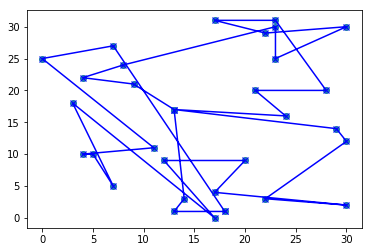

In [18]:
kk=len(zz);
zx=[]
zy=[]
for i in range(kk):
    zx.append(zz[i].x)
    zy.append(zz[i].y)
plt.scatter(zx,zy);
plt.plot([zx[i % kk] for i in range(kk+1)], [zy[i % kk] for i in range(kk+1)], 'xb-');
plt.show()

# Suggestions for additional exercises

1) Re-use this GA, test it with the all-ones problem, having your GA learn to output a string that you enter, or something more exciting!

2) Find a faster algorithm (e.g. pandas).

3) This is very much the canonical GA (though the crossover is slightly different due to the problem scenario). Include additions or alterations to the canonical algorithm to improve the performance.